In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

###
библиотеки

In [2]:
df = pd.read_excel('2020_clean.xlsx', parse_date=True)
df = df.set_index('Date')
df.index = df.asfreq('D').index

### Тут все тоже самое что и в MEAN(), только без bfill

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1153 entries, 2017-01-01 to 2020-02-27
Freq: D
Data columns (total 1 columns):
Q    1153 non-null int64
dtypes: int64(1)
memory usage: 18.0 KB


In [4]:
#df = df.replace(0, np.NaN)

In [5]:
#df.head()

In [6]:
df = df['Q'].resample('MS').mean()

In [7]:
#df = df.fillna(df.bfill())

In [8]:
df.head()

Date
2017-01-01    191440.322581
2017-02-01      6953.142857
2017-03-01     11483.870968
2017-04-01      1186.666667
2017-05-01     21770.548387
Freq: MS, Name: Q, dtype: float64

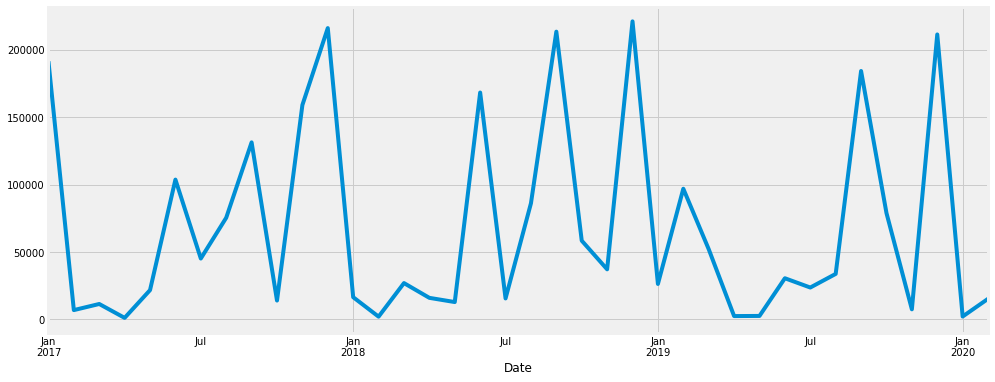

In [9]:
df.plot(figsize=(15,6))

In [10]:
# Определите p, d и q в диапазоне 0-2
p = d = q = range(0, 2)
# Сгенерируйте различные комбинации p, q и q
pdq = list(itertools.product(p, d, q))
# Сгенерируйте комбинации сезонных параметров p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [11]:
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:956.5514831614444
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1058.3289503394421
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:617.0129661174085
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:645.92547998628
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:953.0469876679757
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:347.39984867444645
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:928.5830930461315
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:110849.76552541147
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:595.402519470435
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:659.508046799276
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:761071.2242937074
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:349.629782874578
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:936.2657717503172
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:609.1361343935102
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:635.9945678947983
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:330.95594129416503
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:89

In [12]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

In [13]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0307      1.301     -0.024      0.981      -2.580       2.519
ma.L1         -0.7823      0.623     -1.256      0.209      -2.003       0.439
ar.S.L12      -0.3145      0.597     -0.527      0.598      -1.484       0.855
sigma2      4.266e+09   2.66e-10   1.61e+19      0.000    4.27e+09    4.27e+09


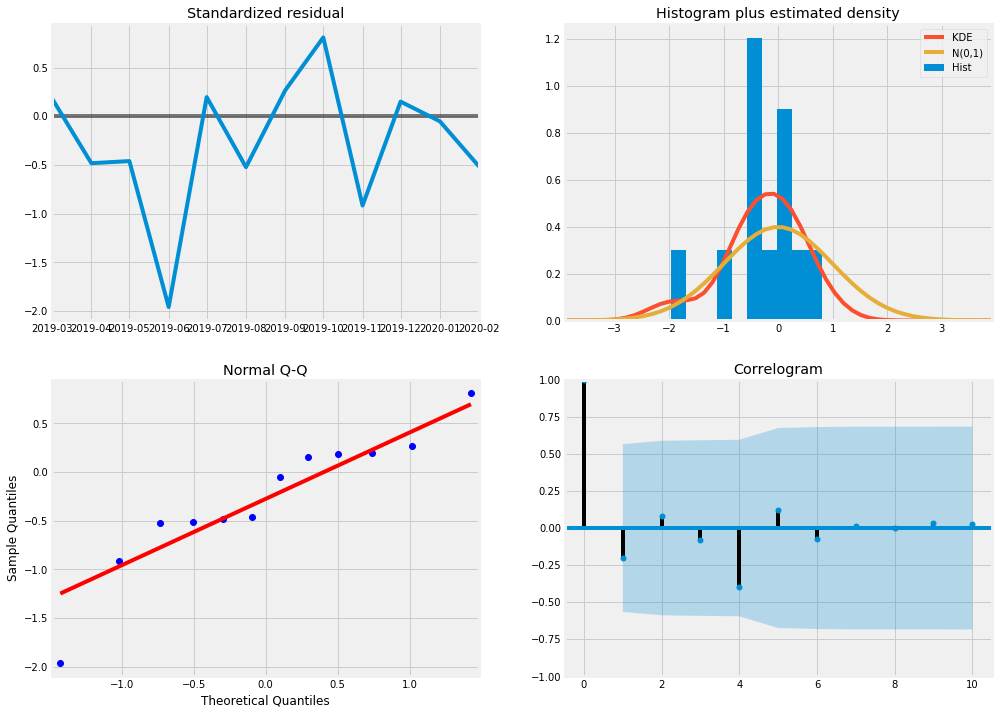

In [14]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()

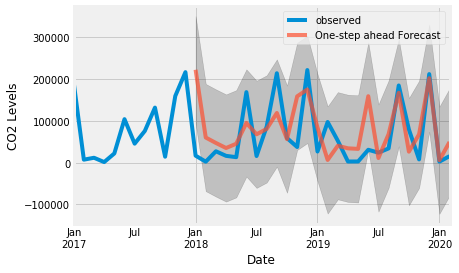

In [16]:
ax = df['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

In [17]:
y_forecasted = pred.predicted_mean
y_truth = df['2018-01-01':]
# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4629733660.67


In [18]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

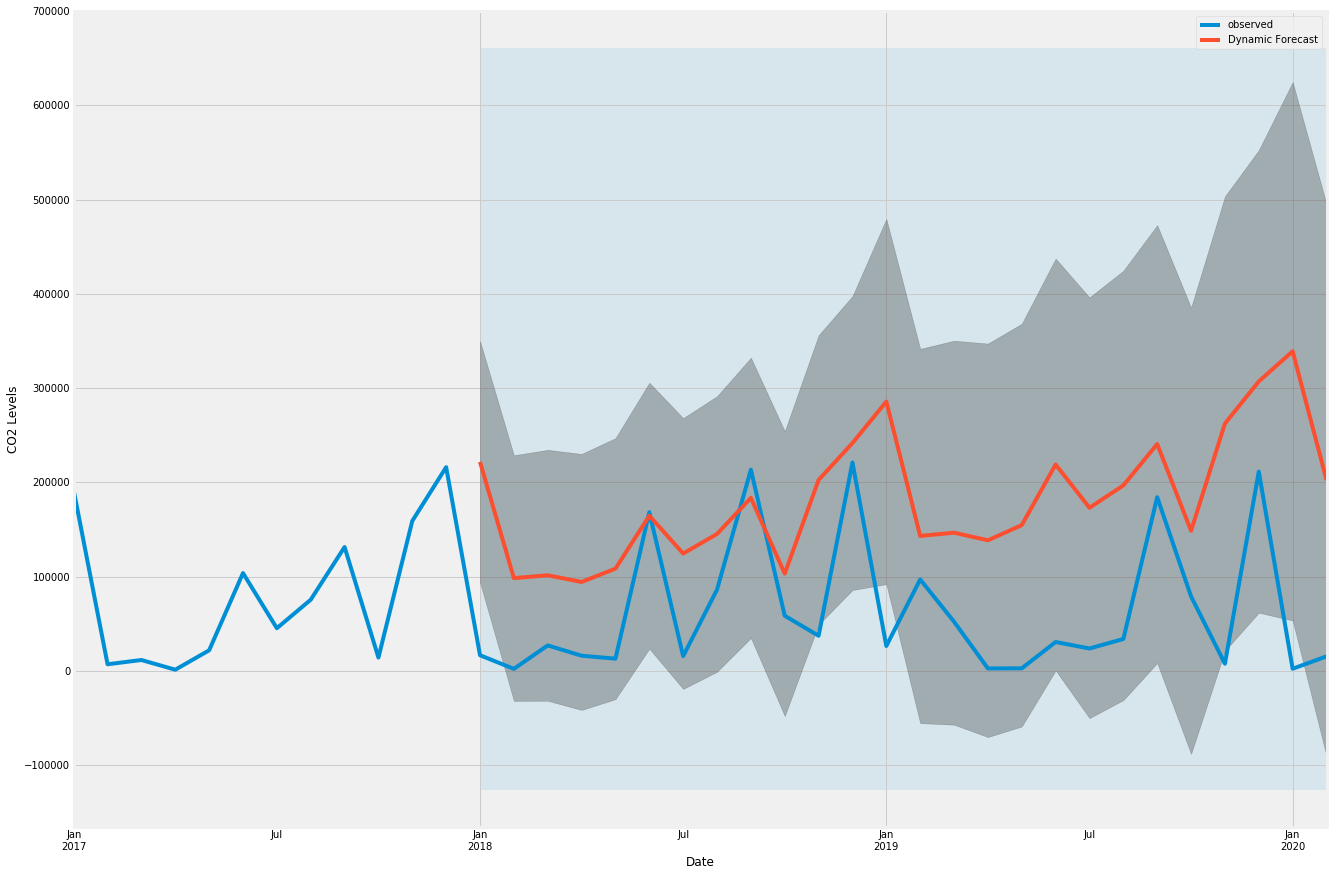

In [19]:
ax = df['2016':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], 
                color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2018-01-01'), df.index[-1],
                 alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

In [20]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = df['2018-01-01':]
# Вычислить среднеквадратичную ошибку
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#The Mean Squared Error of our forecasts is 1.01

The Mean Squared Error of our forecasts is 21266845538.21


In [21]:
# Получить прогноз на 500 шагов вперёд
pred_uc = results.get_forecast(steps=12)
# Получить интервал прогноза
pred_ci = pred_uc.conf_int()

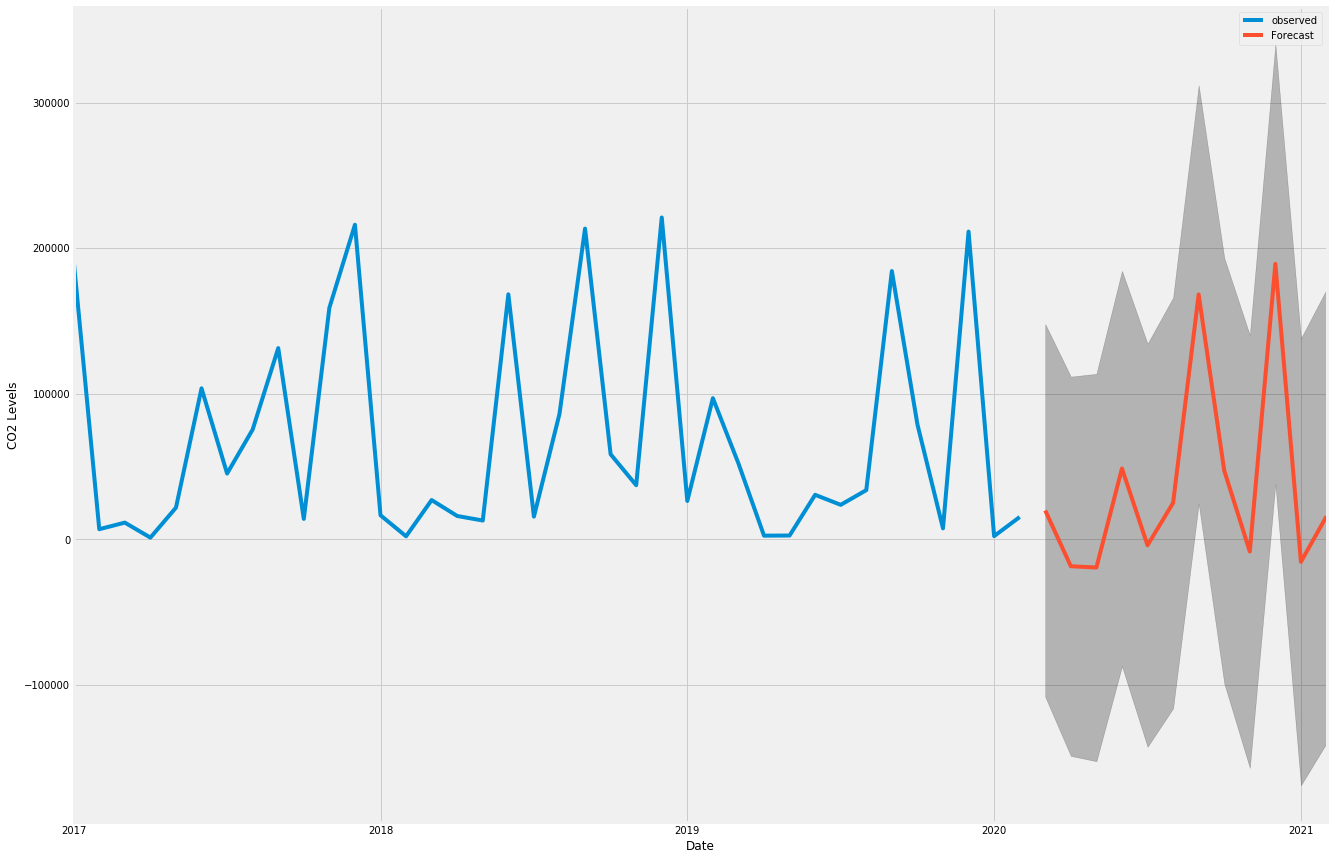

In [22]:
ax = df.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

In [33]:
res = pred_ci.copy()

In [34]:
res

,lower Q,upper Q
2020-03-01,-108214.148298,147819.572427
2020-04-01,-148714.712635,111755.016913
2020-05-01,-152394.736962,113667.590879
2020-06-01,-87096.968511,184403.565057
2020-07-01,-142498.873634,134334.236452
2020-08-01,-116003.148169,166061.705827
2020-09-01,24583.252814,311784.564610
2020-10-01,-98871.982654,193375.523949
2020-11-01,-156968.630797,140239.405323
2020-12-01,38123.859050,340210.979520


In [35]:
res['res'] = res['lower Q'] + res['upper Q']

In [36]:
res['year'] = ''
res['date'] = pd.to_datetime(res.index)

for i in range(len(res['date'])):
    res['year'][i] = res['date'][i].timetuple().tm_year

In [37]:
res['castil'] = res['res'] - float(res.res.min())

In [38]:
res

,lower Q,upper Q,res,year,date,castil
2020-03-01,-108214.148298,147819.572427,39605.424129,2020,2020-03-01,78332.570212
2020-04-01,-148714.712635,111755.016913,-36959.695722,2020,2020-04-01,1767.450361
2020-05-01,-152394.736962,113667.590879,-38727.146083,2020,2020-05-01,0.000000
2020-06-01,-87096.968511,184403.565057,97306.596545,2020,2020-06-01,136033.742628
2020-07-01,-142498.873634,134334.236452,-8164.637182,2020,2020-07-01,30562.508901
2020-08-01,-116003.148169,166061.705827,50058.557658,2020,2020-08-01,88785.703741
2020-09-01,24583.252814,311784.564610,336367.817423,2020,2020-09-01,375094.963507
2020-10-01,-98871.982654,193375.523949,94503.541295,2020,2020-10-01,133230.687378
2020-11-01,-156968.630797,140239.405323,-16729.225473,2020,2020-11-01,21997.920610
2020-12-01,38123.859050,340210.979520,378334.838570,2020,2020-12-01,417061.984653


In [39]:
res.groupby('year').sum()[['res']]

,res
year,
2020,895596.071161
2021,667.210572


In [40]:
res.groupby('year').sum()[['castil']]

,castil
year,
2020,1.282868e+06
2021,7.812150e+04
